-프로젝트 기본설정-

In [81]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

In [82]:
# 경고 메세지 무시
warnings.filterwarnings("ignore")

In [83]:
# 파일 위치 확인
import os
print(os.getcwd())

c:\Users\steve\OneDrive\바탕 화면\mlfinal장승훈


1. 데이터 전처리

    저는 학번 마지막 숫자가 7로 홀수에 해당하니 amazon_uk_shoes_products_dataset_2021_12.csv 를 읽어와서 분석하겠습니다.

In [84]:
# CSV 파일을 읽어 Pandas 데이터프레임으로 로드
df = pd.read_csv('./amazon_uk_shoes_products_dataset_2021_12.csv')

# 데이터프레임의 총 리뷰 수 출력
print(f"Total number of reviews: {df.shape[0]}")

# 데이터프레임의 열 이름 출력
print(f"Dataset Columns: {df.columns}")

Total number of reviews: 6823
Dataset Columns: Index(['url', 'product_name', 'reviewer_name', 'review_title', 'review_text',
       'review_rating', 'verified_purchase', 'review_date', 'helpful_count',
       'uniq_id', 'scraped_at'],
      dtype='object')


In [85]:
# 데이터프레임의 요약 정보 출력
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB
None


In [86]:
# 데이터프레임의 처음 5개 행 출력
print(df.head())

                                      url  \
0  https://www.amazon.co.uk/dp/B07SBX32T5   
1  https://www.amazon.co.uk/dp/B07SBX32T5   
2  https://www.amazon.co.uk/dp/B07SBX32T5   
3  https://www.amazon.co.uk/dp/B07SBX32T5   
4  https://www.amazon.co.uk/dp/B08SW434MG   

                                        product_name     reviewer_name  \
0  Klasified Women's Transparent Clear Sneaker Sh...  Jocelyn McSayles   
1  Klasified Women's Transparent Clear Sneaker Sh...      Kenia Rivera   
2  Klasified Women's Transparent Clear Sneaker Sh...       Chris Souza   
3  Klasified Women's Transparent Clear Sneaker Sh...   Amazon Customer   
4  GUESS Women's Bradly Gymnastics Shoe, White, 7 UK         Graziella   

         review_title                                        review_text  \
0             Love em  Love these. Was looking for converses and thes...   
1  The plastic ripped  The shoes are very cute, but after the 2nd day...   
2        Good quality                                   

In [87]:
# 중복 데이터 확인
dup = df.duplicated(subset=['uniq_id'], keep=False)
# 중복된 행의 개수 확인
count_dup = dup.sum()
print(f"Number of duplicate rows: {count_dup}")

Number of duplicate rows: 364


In [88]:
# 중복 제거 후 행의 수 확인
df_unique = df.drop_duplicates(subset=['uniq_id'], keep='first')
print(f"# of rows after removing duplicates: {len(df_unique)}")

# of rows after removing duplicates: 6641


결측값의 수를 계산한 후 결측값을 제거

In [89]:
# 각 열에서 결측값의 개수를 계산
print(f"Number of missing values in 'review_title': {df_unique['review_title'].isnull().sum()}")
print(f"Number of missing values in 'review_text': {df_unique['review_text'].isnull().sum()}")
print(f"Number of missing values in 'review_rating': {df_unique['review_rating'].isnull().sum()}")

Number of missing values in 'review_title': 1
Number of missing values in 'review_text': 8
Number of missing values in 'review_rating': 0


In [90]:
# 결측값 제거 후 남은 행의 개수 확인
df_cleaned = df_unique.dropna(subset=["review_text", "review_title"])
print(f"Number of rows after removing missing values: {len(df_cleaned)}")

Number of rows after removing missing values: 6632


노이즈 제거, 토큰화 및 불용어 제거, 정규화

In [91]:
# 데이터 전처리
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
special_chars = r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()

    # 특수문자 제거
    text = re.sub(f'[{special_chars}]', '', text)

    # 토큰화
    tokens = nltk.word_tokenize(text)
    
    # 표제어 추출
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(tokens)

# 전처리
df_cleaned['cleaned_review_text'] = df_cleaned['review_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2. 모델 구현

VADER 감성 분석기를 초기화하고, 감성 점수를 계산하는 함수를 선언한 후
텍스트의 감성을 분석하여 compound 점수를 반환합니다.

평점이 4 이상인 경우 긍정, 그렇지 않은 경우 부정으로 분류합니다.

전처리된 텍스트 데이터를 TF-IDF 벡터화하여 수치 벡터로 변환하고 각 단어의 중요도를 반영합니다.
TF-IDF와 감성점수를 결합하여 행렬을 생성하고 모델이 텍스트 내용과 감성을 동시에 학습할 수 있게 합니다.

In [92]:
# VADER 감성 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 감성 점수 계산 함수 선언
def calc_sentiment(review): 
    return vader_sentiment.polarity_scores(review)["compound"]

# 데이터 전처리 및 감성 점수 추가
df_unique = df.drop_duplicates(subset=['uniq_id'], keep='first')
df_cleaned = df_unique.dropna(subset=["review_text", "review_title"])
df_cleaned['cleaned_review_text'] = df_cleaned['review_text'].apply(preprocess_text)
df_cleaned["text_compound"] = df_cleaned["cleaned_review_text"].apply(calc_sentiment)

# 리뷰 평점을 이진 감성 레이블로 변환 (긍정/부정, 임계값: 4)
df_cleaned['sentiment'] = df_cleaned['review_rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')
y = df_cleaned['sentiment']

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df_cleaned['cleaned_review_text']).toarray()

# 감성 점수와 TF-IDF 결합
X_sentiment = df_cleaned[['text_compound']].values
X_combined = np.hstack((X_tfidf, X_sentiment))

3. 모델 학습 및 튜닝

데이터셋을 학습 및 테스트 세트로 분할하고

그리드 서치를 이용하여 하피퍼파라미터 튜닝을 하며 5겹 교차 검증을 통해 각 하이퍼파라미터의 성능을 평가하고

최적의 하이퍼파라미터를 선택합니다.

In [93]:
# 데이터를 학습 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀와 그리드 서치
model = LogisticRegression()
parameters = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

4. 모델 평가

In [94]:
# 모델 평가
y_pred = best_model.predict(X_test)  # 테스트 세트에 대한 예측
y_prob = best_model.predict_proba(X_test)[:, 1]  # 양성 클래스의 예측 확률

# 정확도, 정밀도, 재현율, F1 점수, ROC-AUC 점수 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')
roc_auc = roc_auc_score(y_test, y_prob)

# 평가 결과 출력
print(f'Accuracy: {accuracy}')  # 정확도 출력
print(f'Precision: {precision}')  # 정밀도 출력
print(f'Recall: {recall}')  # 재현율 출력
print(f'F1 Score: {f1}')  # F1 점수 출력
print(f'ROC-AUC: {roc_auc}')  # ROC-AUC 점수 출력

Accuracy: 0.8568198944988696
Precision: 0.8877455565949486
Recall: 0.9313052011776252
F1 Score: 0.9090038314176245
ROC-AUC: 0.8850652536864508


정확도 (Accuracy): 약 0.85
대부분의 경우에 대해 올바르게 예측했지만 살짝 아쉬운 수치입니다.

정밀도 (Precision) : 약 0.88
대부분의 경우에 대해 올바르게 예측 했음을 알 수 있습니다.

재현율 (Recall) : 약 0.93
90% 이상의 높은 수치로, 대부분의 경우에 대해 올바르게 예측 했음을 알 수 있습니다.

F1 점수 (F1 Score) : 약 0.90
이 역시 높은 수치로, 우수한 성능을 보였음을 의미합니다.

ROC-AUC 점수 (ROC-AUC) : 약 0.88
꽤 높은 수치로 양성과 음성을 잘 구분하는것으로 보입니다.




5. 시각화 및 보고

True Negative (TN): 188
모델이 실제 부정 리뷰를 부정으로 정확히 예측한 수

False Positive (FP): 120
모델이 실제 부정 리뷰를 긍정으로 잘못 예측한 수

False Negative (FN): 70
모델이 실제 긍정 리뷰를 부정으로 잘못 예측한 수

True Positive (TP): 949
모델이 실제 긍정을 긍정으로 정확히 예측한 수

ROC 곡선이 대각선 기준선보다 위에 위치할수록 더 우수한 모델임을 뜻하는데, 이 모델이 대각선보다 위에 위치하여

좋은 성능을 낸다는 것을 알 수 있습니다.

AUC는 0.89로, 모델이 양성과 음성을 잘 구분하고 있음을 뜻합니다.

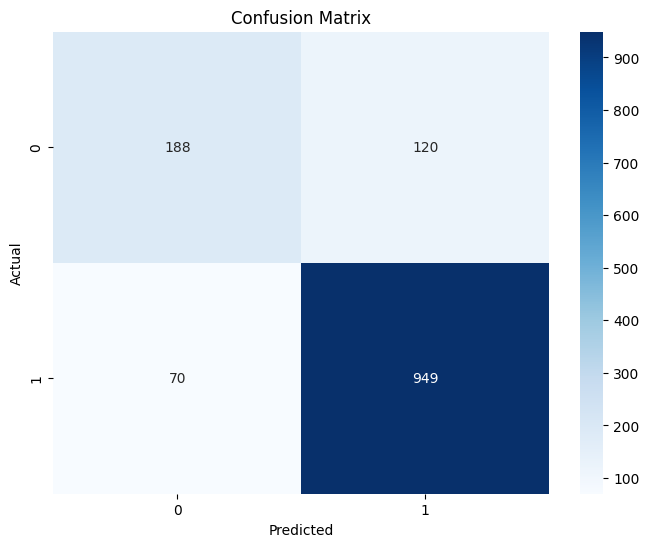

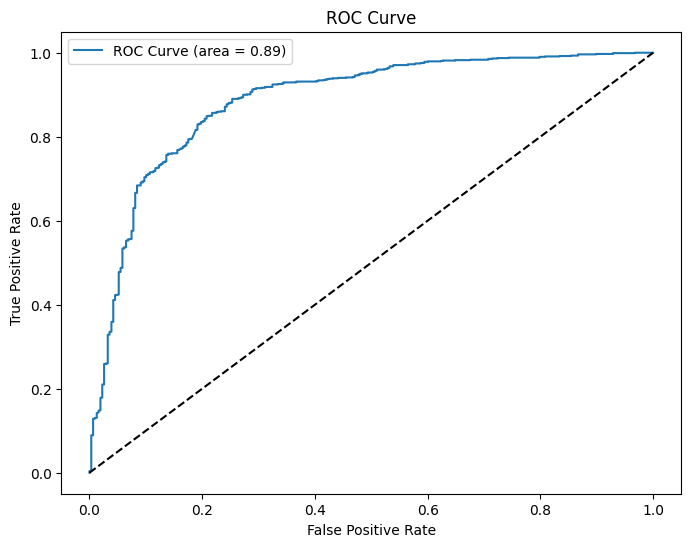

In [96]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 시각화
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='positive')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
